## Desafio de Regressão

Objetivo 1 - Interpretabilidade <p>
Objetivo 2 - Poder Preditivo

In [59]:
#conda install -c anaconda scikit-learn

In [60]:
#conda install -c conda-forge category_encoders

### Importando bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Modelling libs
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance
from sklearn.inspection import permutation_importance


# Stats libs
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
):

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

### Importando a base

In [4]:
df = pd.read_csv('base.csv')
df.drop('Id', axis=1, inplace=True)

In [64]:
print(df.shape)
print(df.head())

(1460, 80)
   ClasseImovel ClasseZona  Fachada  TamanhoLote   Rua Beco FormaProp  \
0            60         RL     65.0         8450  Pave  NaN       Reg   
1            20         RL     80.0         9600  Pave  NaN       Reg   
2            60         RL     68.0        11250  Pave  NaN       IR1   
3            70         RL     60.0         9550  Pave  NaN       IR1   
4            60         RL     84.0        14260  Pave  NaN       IR1   

  PlanoProp Servicos ConfigLote  ... AreaPiscina QualidadePiscina  \
0       Lvl   AllPub     Inside  ...           0              NaN   
1       Lvl   AllPub        FR2  ...           0              NaN   
2       Lvl   AllPub     Inside  ...           0              NaN   
3       Lvl   AllPub     Corner  ...           0              NaN   
4       Lvl   AllPub        FR2  ...           0              NaN   

  QualidadeCerca Outros ValorOutros MesVenda  AnoVenda  TipoVenda  \
0            NaN    NaN           0        2      2008         WD 

In [5]:
# Variavel de interesse
target = 'PrecoVenda'
# Variaveis numericas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove('ClasseImovel')
num_vars.remove(target)

# Variaveis categorical
cat_vars = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.append('ClasseImovel')

## Análise Exploratória

Qualidade, Área Construída, Área da Garagem, Carros na Garagem, Área Térreo e Área Porão são as variáveis com maior valor de correlação com o target

In [6]:
## Matriz de correlação entre variáveis numéricas
corr = df[num_vars + [target]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Fachada,TamanhoLote,Qualidade,Condicao,AnoConstrucao,AnoReforma,AreaAlvenaria,AreaAcabPorao1,AreaAcabPorao2,AreaInacabPorao,AreaPorao,AreaTerreo,Area2Andar,BaixaQualiAreaAcab,AreaConstruida,BanheiroPorao,LavaboPorao,Banheiro,Lavabo,BedroomAbvGr,KitchenAbvGr,TotalQuartos,Lareira,AnoGaragem,CarrosGaragem,AreaGaragem,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,PrecoVenda
Fachada,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
TamanhoLote,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
Qualidade,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
Condicao,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
AnoConstrucao,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
AnoReforma,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
AreaAlvenaria,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
AreaAcabPorao1,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
AreaAcabPorao2,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.088011,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
AreaInacabPorao,0.132644,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.114442,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.190708,0.214175,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


Para muitas variáveis (e.g. Área garagem, área alvenaria), há uma alta concentração na variável zero, o que pode significar que ela está faltando (e.g., o imóvel não tem garagem)

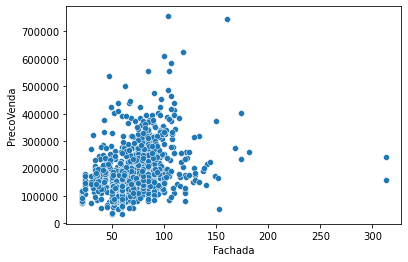

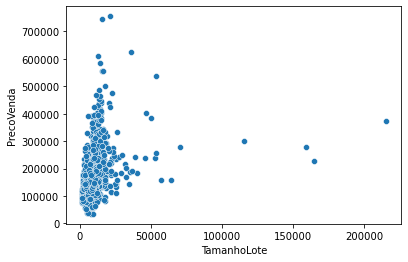

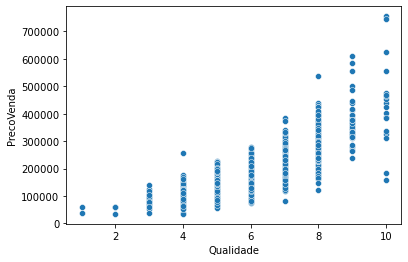

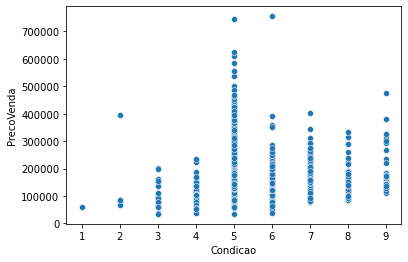

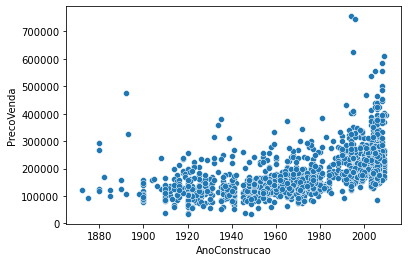

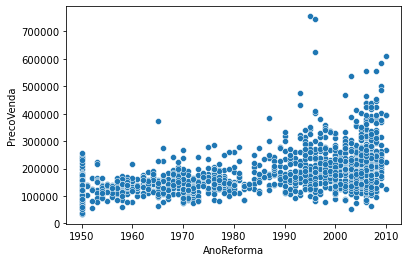

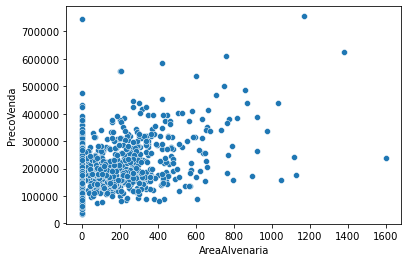

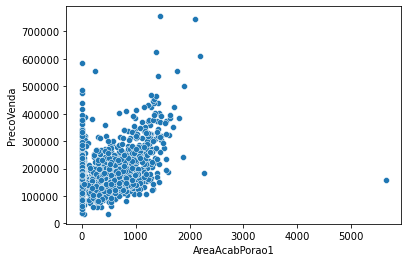

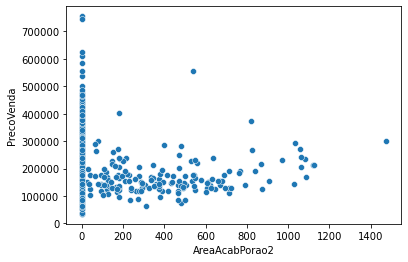

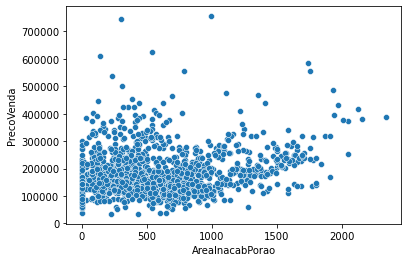

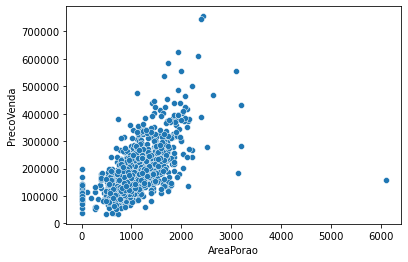

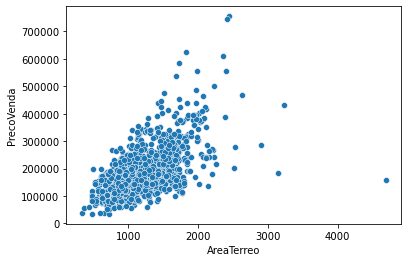

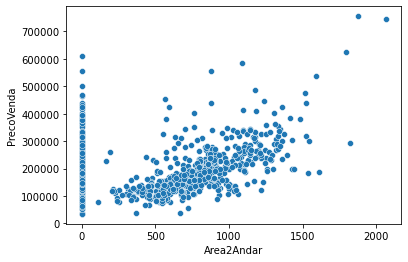

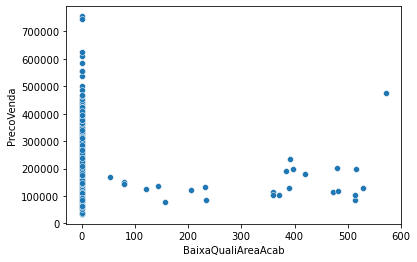

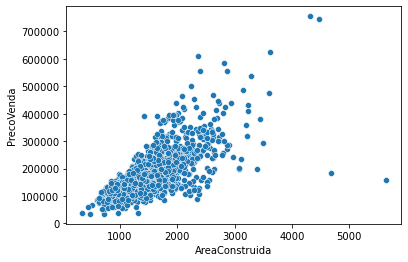

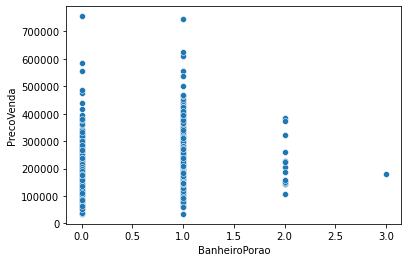

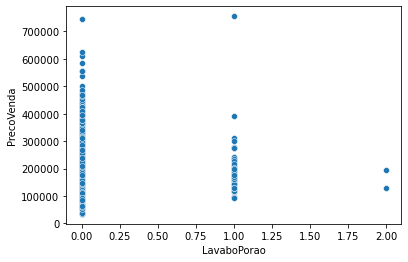

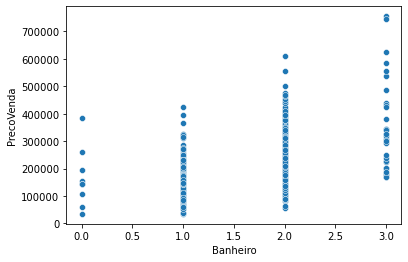

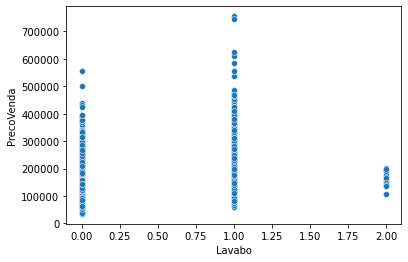

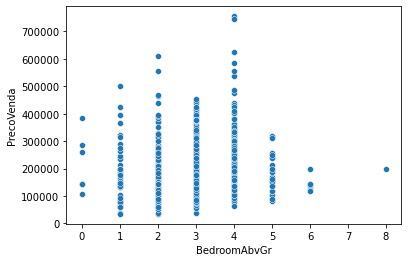

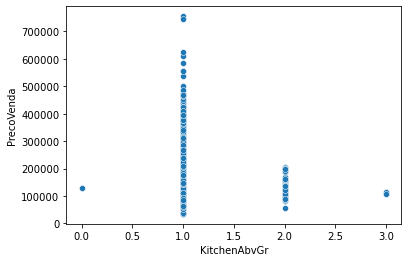

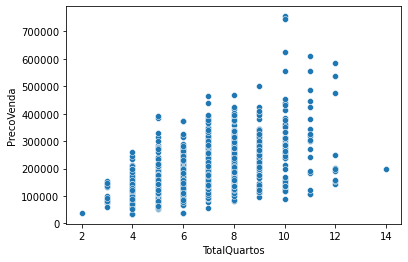

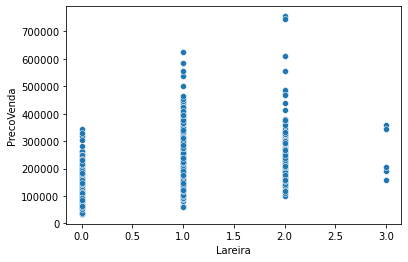

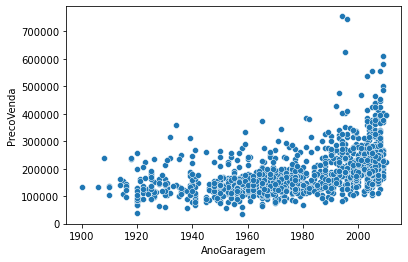

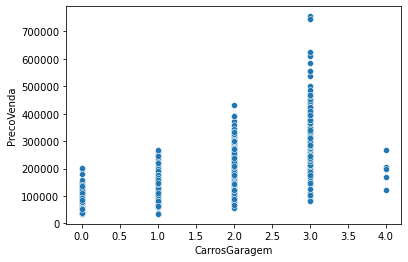

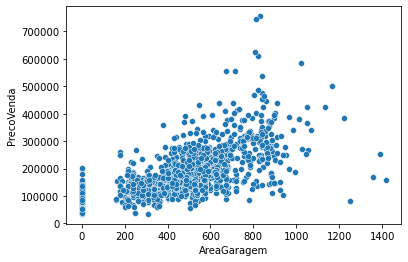

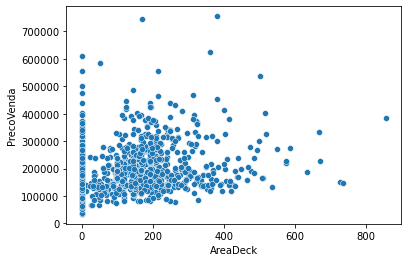

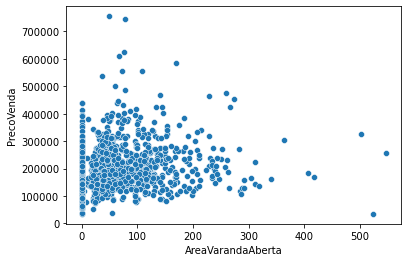

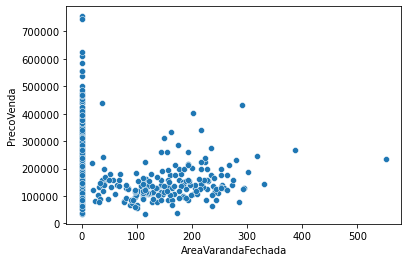

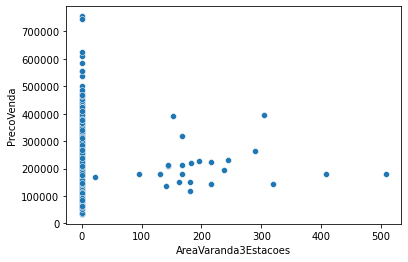

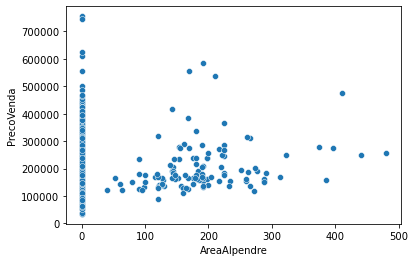

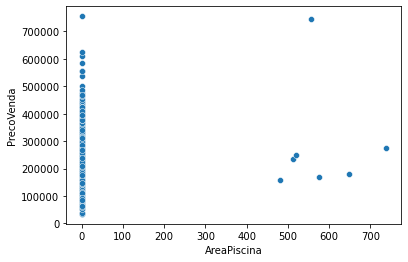

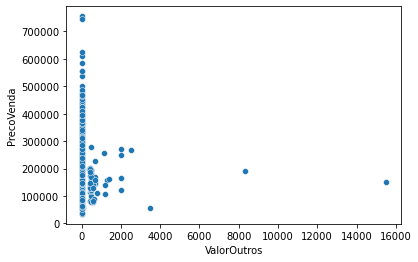

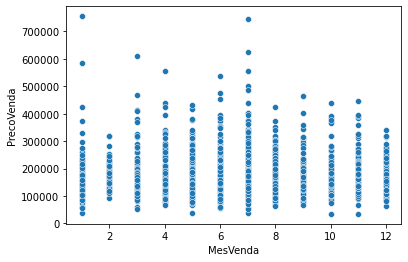

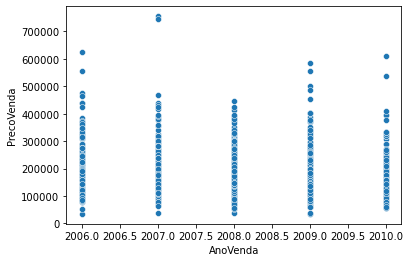

In [7]:
### Scatterplot entre as variáveis numéricas

for i in num_vars:
    sns.scatterplot(data = df, x = i, y = 'PrecoVenda')
    plt.show()    

A partir da análise de valores faltantes, já podemos descartar algumas variáveis

In [8]:
#Analisando as variáveis faltantes
valores_faltantes = df.isnull().sum()
valores_faltantes[valores_faltantes > 0].sort_values(ascending = False)

QualidadePiscina      1453
Outros                1406
Beco                  1369
QualidadeCerca        1179
QualdiadeLareira       690
Fachada                259
LocalGaragem            81
AnoGaragem              81
AcabamentoGaragem       81
QualidadeGaragem        81
CondicaoGaragem         81
ParedePorao             38
TipoAcabPorao2          38
TipoAcabPorao1          37
CondicaoPorao           37
AlturaPorao             37
AreaAlvenaria            8
TipoAlvenaria            8
InstalacaoEletrica       1
dtype: int64

Parece haver bastante variabilidade de preço entre as diferentes classes das variáveis categóricas, ou seja, elas podem ser úteis na predição

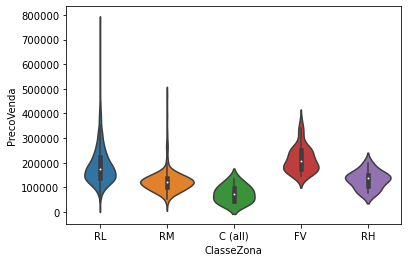

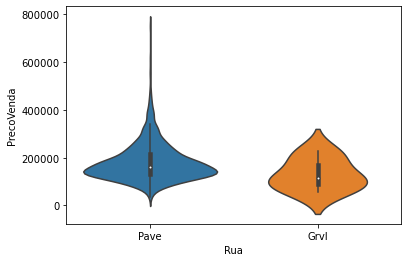

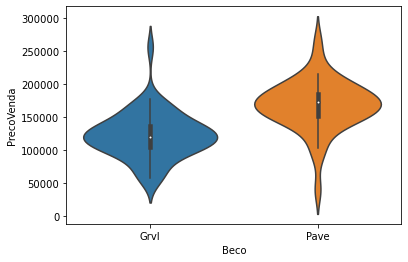

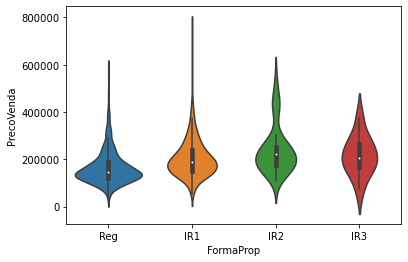

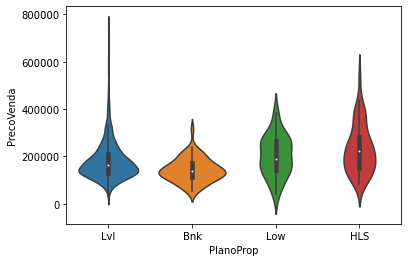

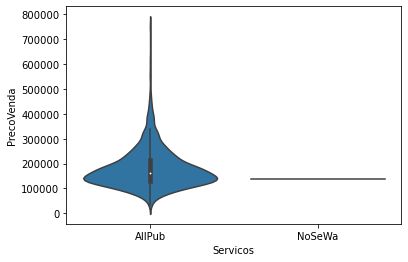

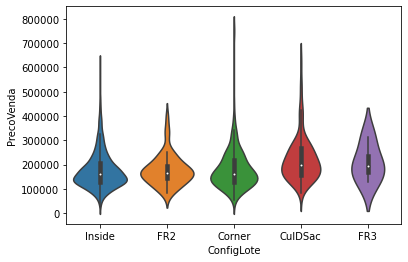

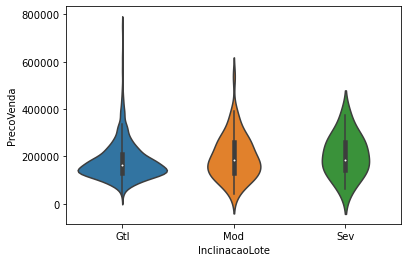

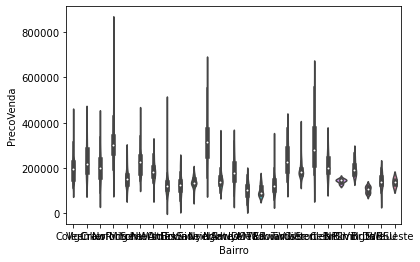

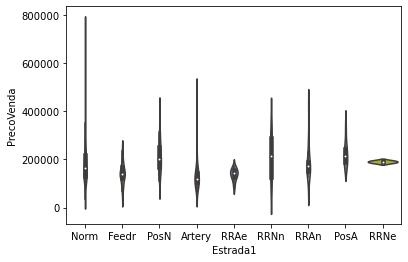

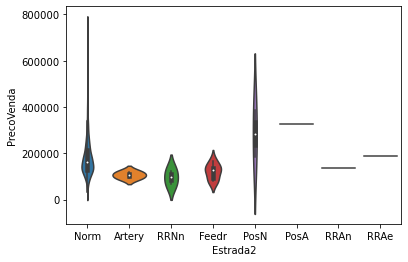

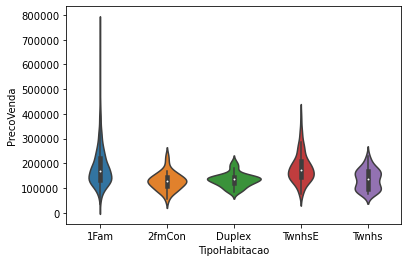

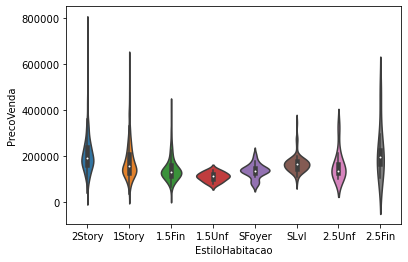

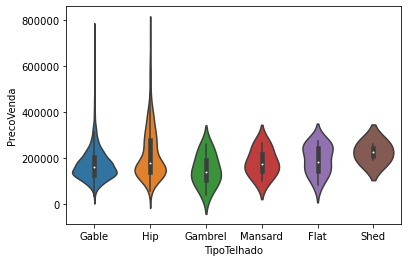

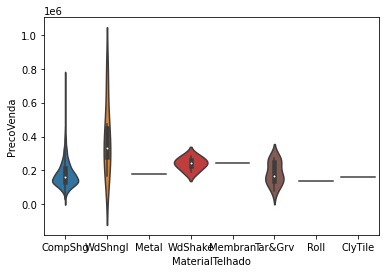

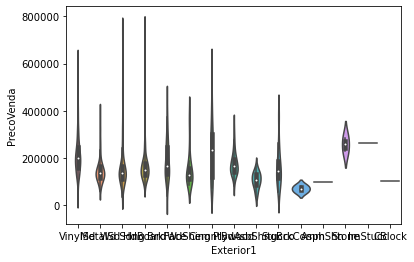

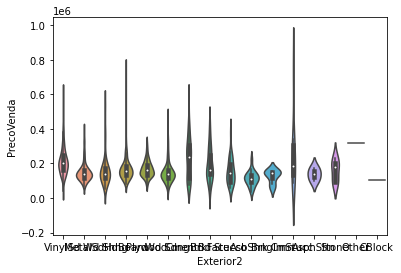

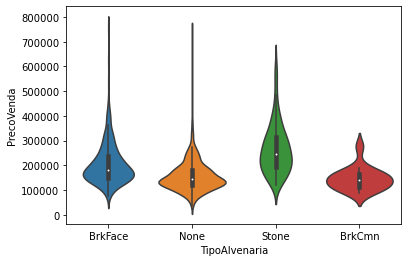

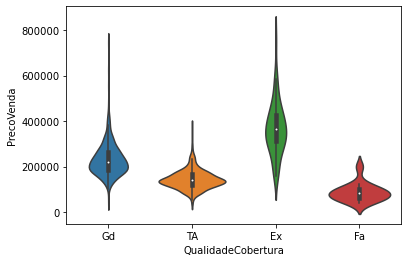

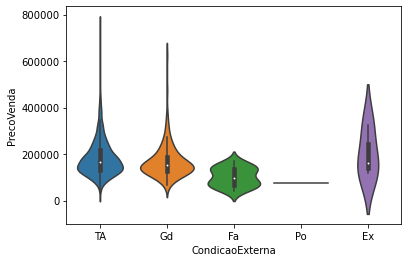

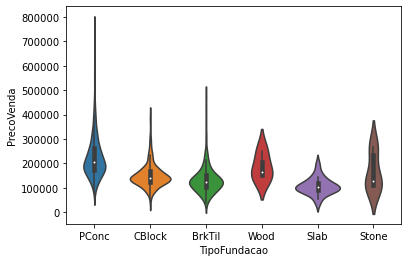

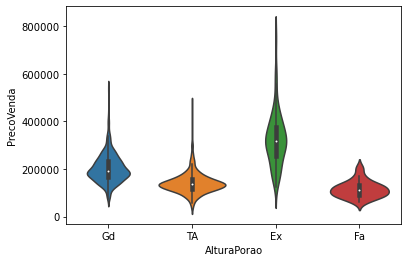

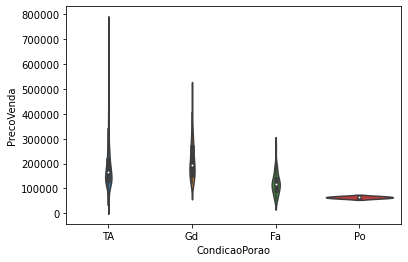

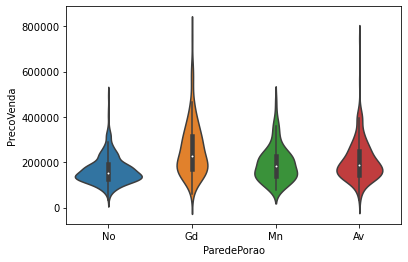

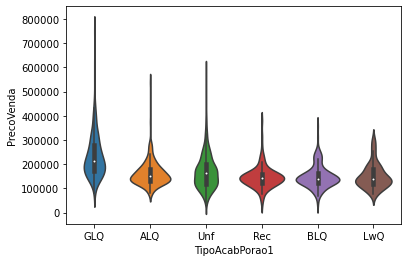

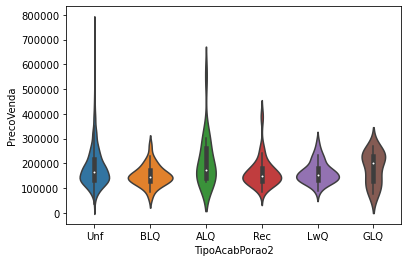

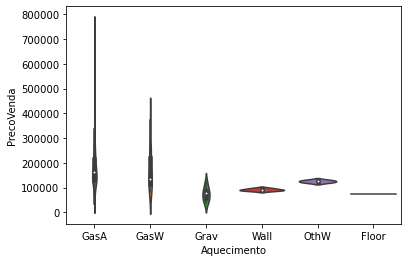

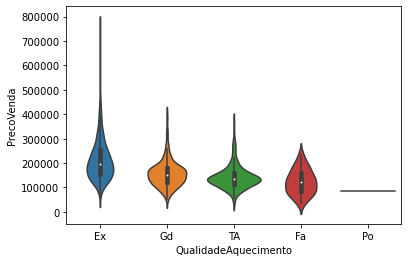

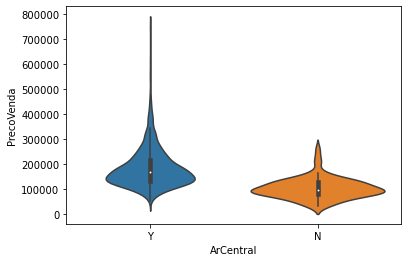

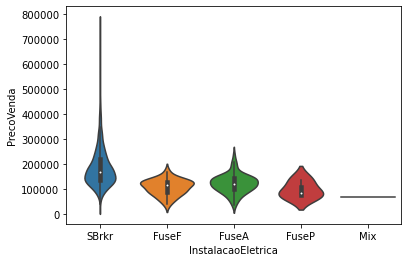

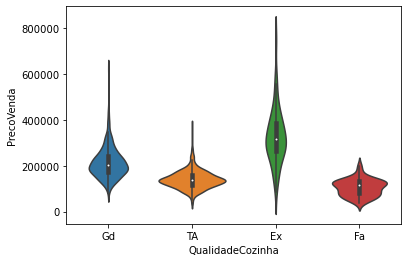

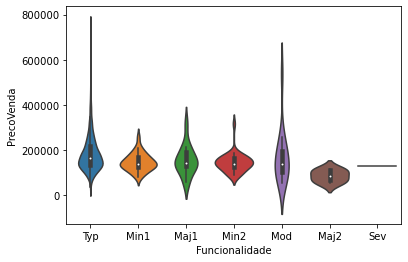

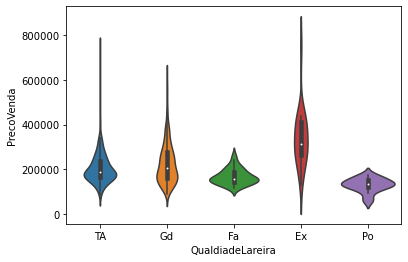

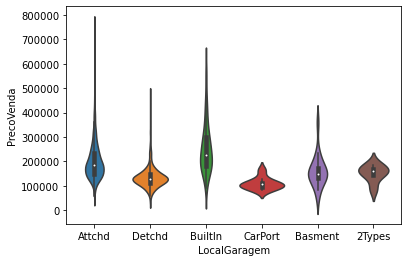

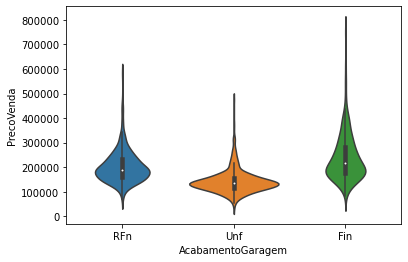

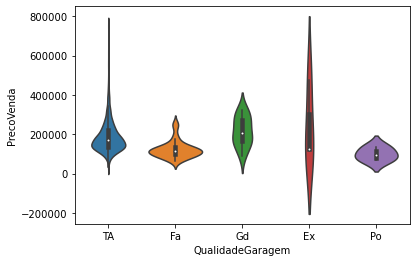

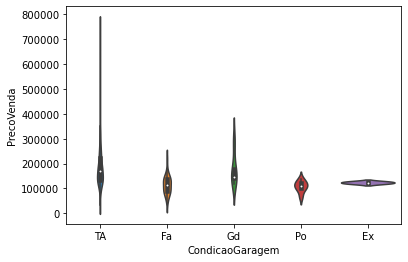

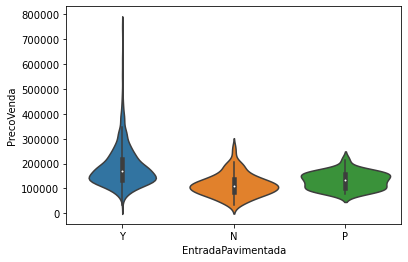

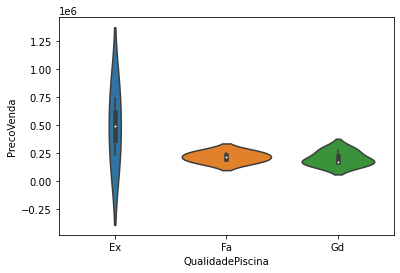

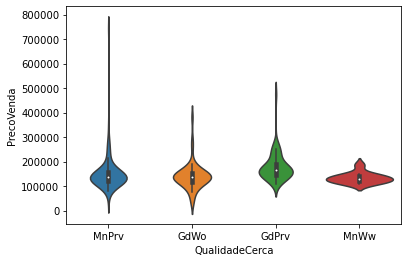

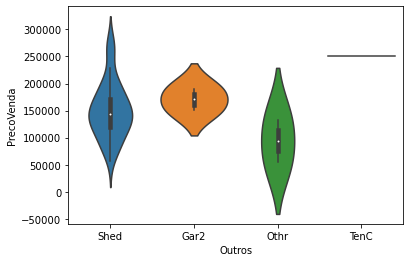

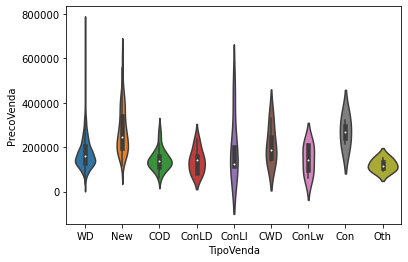

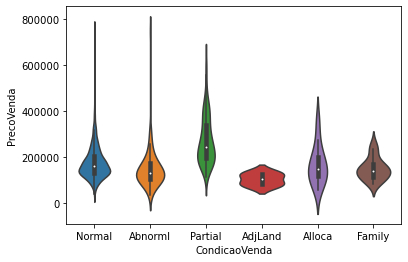

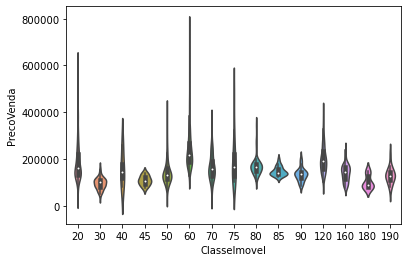

In [9]:
#Analisando a relação do target com as variáveis categóricas
for i in cat_vars:
    sns.violinplot(data = df, x = i, y = target)
    plt.show()

O histograma dos preços parece enviesado para a esquerda - a transformação em log pode ajudar a "normalizar"

<AxesSubplot:xlabel='PrecoVenda', ylabel='Count'>

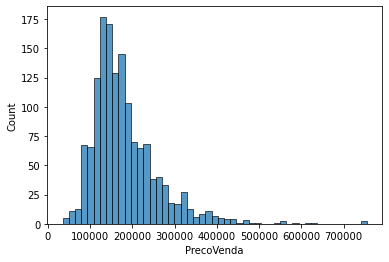

In [10]:
sns.histplot(df[target])

De fato, a transformação log faz a distribuição parecer mais com a normal

<AxesSubplot:xlabel='LogPreco', ylabel='Count'>

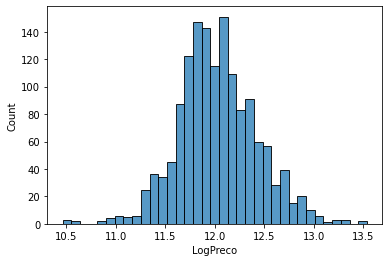

In [11]:
df['LogPreco'] = np.log(df[target])
sns.histplot(df['LogPreco'])

### Pré-Preprocessamento, limpeza dos dados, construção de features

In [12]:
## Selecionando colunas com muitos missings

cols_to_drop = valores_faltantes[valores_faltantes > 1000]
cols_to_drop = list(cols_to_drop.reset_index()['index'])
cols_to_drop

['Beco', 'QualidadePiscina', 'QualidadeCerca', 'Outros']

Construindo novas features com as variáveis de área

In [13]:
## Identificando variáveis relacionadas a área

area_vars = list(df.filter(regex='Area').columns)
area_vars.remove('AreaConstruida')
area_vars

['AreaAlvenaria',
 'AreaAcabPorao1',
 'AreaAcabPorao2',
 'AreaInacabPorao',
 'AreaPorao',
 'AreaTerreo',
 'Area2Andar',
 'BaixaQualiAreaAcab',
 'AreaGaragem',
 'AreaDeck',
 'AreaVarandaAberta',
 'AreaVarandaFechada',
 'AreaVaranda3Estacoes',
 'AreaAlpendre',
 'AreaPiscina']

In [14]:
# Construindo novas features
novas_features = df[area_vars].div(df['AreaConstruida'], axis = 0)
novas_features.columns = [var + '_sobreAreaConstruida' for var in area_vars]
novas_features.head()

,AreaAlvenaria_sobreAreaConstruida,AreaAcabPorao1_sobreAreaConstruida,AreaAcabPorao2_sobreAreaConstruida,AreaInacabPorao_sobreAreaConstruida,AreaPorao_sobreAreaConstruida,AreaTerreo_sobreAreaConstruida,Area2Andar_sobreAreaConstruida,BaixaQualiAreaAcab_sobreAreaConstruida,AreaGaragem_sobreAreaConstruida,AreaDeck_sobreAreaConstruida,AreaVarandaAberta_sobreAreaConstruida,AreaVarandaFechada_sobreAreaConstruida,AreaVaranda3Estacoes_sobreAreaConstruida,AreaAlpendre_sobreAreaConstruida,AreaPiscina_sobreAreaConstruida
0,0.114620,0.412865,0.0,0.087719,0.500585,0.500585,0.499415,0.0,0.320468,0.000000,0.035673,0.000000,0.0,0.0,0.0
1,0.000000,0.774960,0.0,0.225040,1.000000,1.000000,0.000000,0.0,0.364501,0.236133,0.000000,0.000000,0.0,0.0,0.0
2,0.090705,0.272116,0.0,0.243001,0.515118,0.515118,0.484882,0.0,0.340426,0.000000,0.023516,0.000000,0.0,0.0,0.0
3,0.000000,0.125801,0.0,0.314502,0.440303,0.559697,0.440303,0.0,0.373908,0.000000,0.020384,0.158416,0.0,0.0,0.0
4,0.159236,0.297998,0.0,0.222930,0.520928,0.520928,0.479072,0.0,0.380346,0.087352,0.038217,0.000000,0.0,0.0,0.0


In [15]:
## Processando
df_processed = pd.concat([df, novas_features], axis = 1)
df_processed.drop(cols_to_drop, axis = 1, inplace = True)
df_processed.shape

(1460, 92)

## 1. Objetivo I - Regressão Linear para interpretabilidade

In [16]:
df_interpret = df_processed.loc[df_processed['CondicaoVenda'] == 'Normal'].copy()
print(df_interpret.shape)
print(df_interpret.columns)

(1198, 92)
Index(['ClasseImovel', 'ClasseZona', 'Fachada', 'TamanhoLote', 'Rua',
       'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote',
       'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao',
       'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'TipoTelhado',
       'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria',
       'AreaAlvenaria', 'QualidadeCobertura', 'CondicaoExterna',
       'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao',
       'TipoAcabPorao1', 'AreaAcabPorao1', 'TipoAcabPorao2', 'AreaAcabPorao2',
       'AreaInacabPorao', 'AreaPorao', 'Aquecimento', 'QualidadeAquecimento',
       'ArCentral', 'InstalacaoEletrica', 'AreaTerreo', 'Area2Andar',
       'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao',
       'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr',
       'QualidadeCozinha', 'TotalQuartos', 'Funcionalidade', 'Lareira',
       'QualdiadeLareira', 'LocalGaragem', '

In [17]:
df_interpret = pd.get_dummies(df_interpret, columns=['ArCentral'], drop_first=True)

In [18]:
##Variáveis escolhidas
var_interpret = ['AreaConstruida', 'CarrosGaragem', 'ArCentral_Y', 'Qualidade',  'AreaPorao', 'Banheiro']
formula ="LogPreco ~ " + ' + '.join(var_interpret)
# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df_interpret).fit()

# Plotando o sumario do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPreco   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1139.
Date:                Sat, 18 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:29:07   Log-Likelihood:                 644.77
No. Observations:                1198   AIC:                            -1276.
Df Residuals:                    1191   BIC:                            -1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.4485      0.022    466.

In [19]:
## Matriz de correlação entre as variáveis
corr = df_interpret[var_interpret].corr()
corr.style.background_gradient(cmap='coolwarm')

,AreaConstruida,CarrosGaragem,ArCentral_Y,Qualidade,AreaPorao,Banheiro
AreaConstruida,1.000000,0.465061,0.076536,0.576861,0.383522,0.650396
CarrosGaragem,0.465061,1.000000,0.211898,0.564465,0.409797,0.452606
ArCentral_Y,0.076536,0.211898,1.000000,0.255123,0.202598,0.074507
Qualidade,0.576861,0.564465,0.255123,1.000000,0.494476,0.525825
AreaPorao,0.383522,0.409797,0.202598,0.494476,1.000000,0.304859
Banheiro,0.650396,0.452606,0.074507,0.525825,0.304859,1.000000


A distribuição dos erros parece normal

<AxesSubplot:ylabel='Count'>

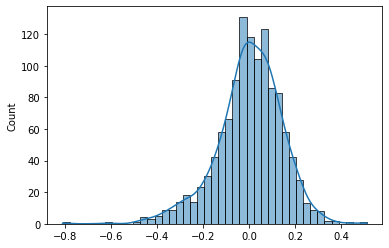

In [20]:
#Checando distribuição dos erros
sns.histplot(model.resid, kde=True)

Não parece haver heterocedasticidade

<AxesSubplot:xlabel='AreaConstruida'>

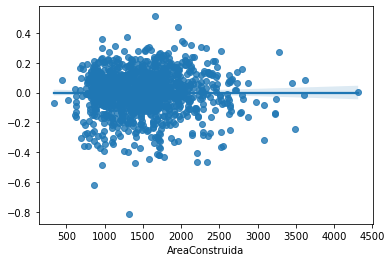

In [21]:
#Checando heterocedastcidade (aumento da variância com o aumento de X - nesse exemplo, área construída)
sns.regplot(x=df_interpret.AreaConstruida , y=model.resid)

In [22]:
##Ajustando os parametros para interpretabilidade
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.02
CarrosGaragem      9.41
ArCentral_Y       24.58
Qualidade         10.58
AreaPorao          0.02
Banheiro           1.56
dtype: float64

O aumento em uma unidade dessas variáveis aumenta o preço em x% (por exemplo, o aumento em m2 de área construída aumenta o preço em 0.02%)

## 2. Objetivo II - Poder Preditivo

In [23]:
# Features numericas
num_features = df_processed.select_dtypes(include=['int', 'float']).columns.tolist()
num_features = [i for i in num_features if i not in ['PrecoVenda','LogPreco']]

# Features categoricas
cat_features = df_processed.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_features = [i for i in cat_features if i not in cols_to_drop]
df_processed[cat_features] = df_processed[cat_features].astype("category")
# features_to_remove = ['AnoVenda', 'LogPrecoVenda', 'PrecoVenda']

In [24]:
features = num_features + cat_features
(
  X_train, X_test, 
  X_val, y_train, 
  y_test, y_val
) = train_test_valid_split(df_processed, features=features, target= 'PrecoVenda', test_size=0.3, valid_size=0.5, random_state=42)

Preenchendo missings categóricos com a moda, missings numéricos com mediana, strings por códigos numéricos

In [25]:
def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Categoricals pre-processing (categorical encoders)
  target_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 99)
  X_train[cat_features] = target_encoder.fit_transform(X_train[cat_features])
  X_val[cat_features] = target_encoder.transform(X_val[cat_features])
  X_test[cat_features] = target_encoder.transform(X_test[cat_features])

  # Numerical pre-processing (missing imputer)
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
  X_val[num_features] = num_imputer.transform(X_val[num_features])
  X_test[num_features] = num_imputer.transform(X_test[num_features])

  return X_train, X_val, X_test

In [26]:
X_train, X_val, X_test = random_forest_preprocessing(X_train.copy(), X_val.copy(), X_test.copy(), y_train)

In [33]:
#Fitando baseline
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)
#Predict
y_pred = rf_baseline.predict(X_val)

print("mean squared error é ", round(math.sqrt(mean_squared_error(y_val, y_pred)), 2))
print("mean absolute error é ", mean_absolute_error(y_val, y_pred))
print("r2 score é ", r2_score(y_val, y_pred))

mean squared error é  29339.74
mean absolute error é  17438.237260273974
r2 score é  0.8868877364322088


In [35]:
#Otimizando
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [36]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [39]:
y_val_best_pred = rf_random.best_estimator_.predict(X_val)

print("mean squared error é ", round(math.sqrt(mean_squared_error(y_val, y_val_best_pred)), 2))
print("mean absolute error é ", mean_absolute_error(y_val, y_val_best_pred))
print("r2 score é ", r2_score(y_val, y_val_best_pred))

mean squared error é  29701.12
mean absolute error é  16788.25495333736
r2 score é  0.8840841801788135


### Importância das features

In [166]:
permutation_result = permutation_importance(rf_random.best_estimator_, X_val, y_val, n_repeats=5, random_state=42)

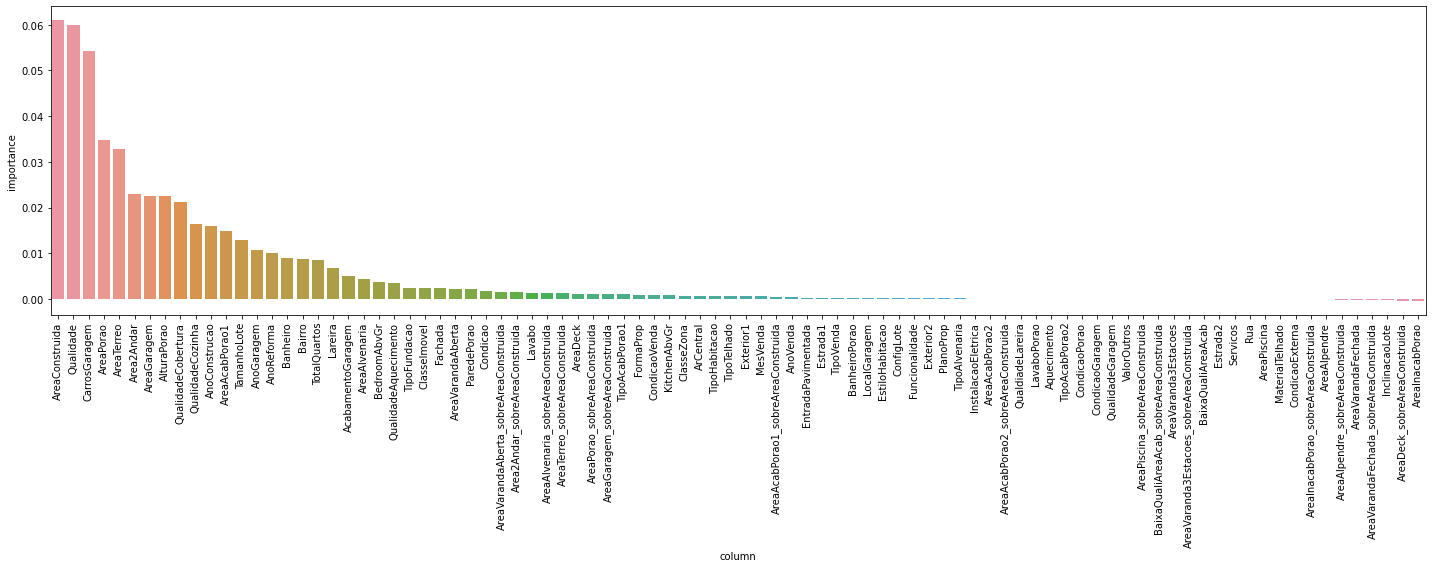

In [167]:
importances = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [168]:
# Getting the top 40 best features
best_features = importances.head(25).column.tolist()
print(best_features)

['AreaConstruida', 'Qualidade', 'CarrosGaragem', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'AreaGaragem', 'AlturaPorao', 'QualidadeCobertura', 'QualidadeCozinha', 'AnoConstrucao', 'AreaAcabPorao1', 'TamanhoLote', 'AnoGaragem', 'AnoReforma', 'Banheiro', 'Bairro', 'TotalQuartos', 'Lareira', 'AcabamentoGaragem', 'AreaAlvenaria', 'BedroomAbvGr', 'QualidadeAquecimento', 'TipoFundacao', 'ClasseImovel']


In [169]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_val[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
val_report = metrics_report(y_val, y_val_pred, 'validation')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report, val_report[['validation']],  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(features)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 90)
            metric  validation
0             RMSE    29607.49
1              MAE    16777.27
2              R^2        0.88
3             MAPE        0.09
4      Avg. target   174313.75
5  Avg. Prediction   172326.15

Final report (total features: 25)
            metric      train  validation       test
0             RMSE   11765.26    26743.60   23518.02
1              MAE    6630.08    16754.99   15769.20
2              R^2       0.98        0.91       0.91
3             MAPE       0.04        0.10       0.10
4      Avg. target  181312.69   174313.75  185701.65
5  Avg. Prediction  181155.52   172183.25  185828.36


Running permutation feature importance with the final model on the held-out testing set


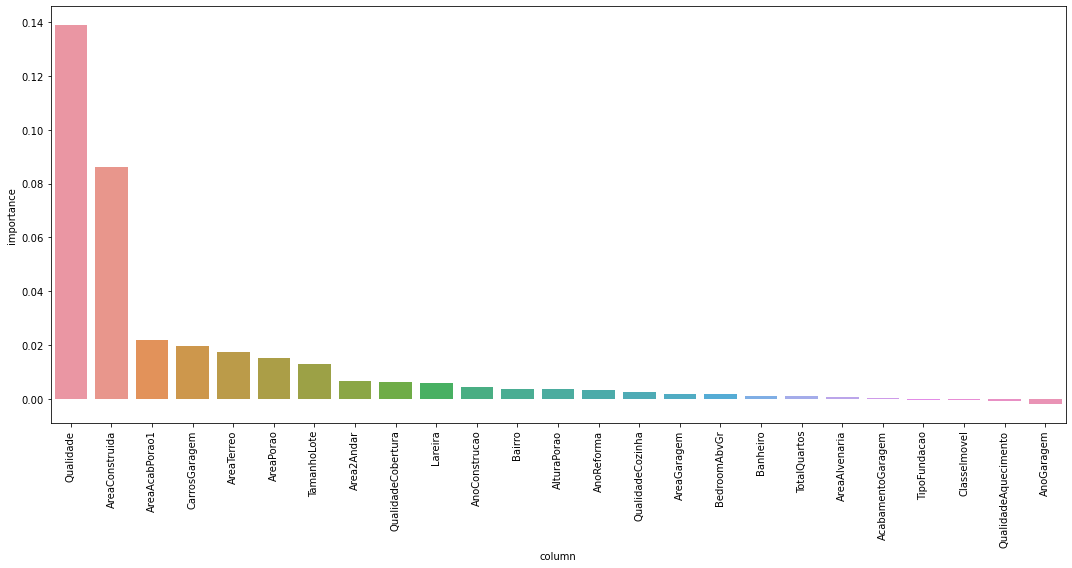

In [170]:
print('Running permutation feature importance with the final model on the held-out testing set')
permutation_result = permutation_importance(rf_model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()